# DMT
Mazeworld with discrete morse theory

In [1]:
import sys

sys.path.append("../src")

from environments import MazeEnv
from policies import BaseAgent, QLearningAgent
from dmt import environment_to_graph, classify_simplices, visualize_graph

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
env = MazeEnv()
agent = BaseAgent(env, gamma=0.999)
agent.value_iteration(threshold=1e-8, max_iterations=100000)
optimal_value_function = agent.value_function

In [3]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=0.999, alpha=0.01)
agent.compute_optimal_q_function(threshold=1e-8, max_iterations=100000)
optimal_q_function = agent.q_table

Optimal Q-function computed.


In [4]:
# check if max_a q_{opt}(s, a) == v_{opt{(s)
np.allclose(np.max(optimal_q_function, axis=-1), optimal_value_function, rtol=1e-5, atol=1e-5)

True

# Env to graph
Convert a gymnasium environment to a graph. We connect states $s$ and $s'$ with an edge if an action at $s$ can take us to $s'$. For now we assume the graph is undirected.

We assign a real-valued function on the verticies as determined by the value function. Edge values are automatically determined by the definition of a flat discrete Morse function.

In [5]:
G = environment_to_graph(env, optimal_q_function)

In [6]:
list(G.nodes(data=True))[:5]

[(0, {'node_value': -12.922024173243887}),
 (8, {'node_value': -11.933958141372973}),
 (1, {'node_value': -11.934081584720854}),
 (2, {'node_value': -10.945027622330898}),
 (3, {'node_value': -9.954984616935544})]

In [7]:
list(G.edges(data=True))[:5]

[(0, 8, {'edge_value': -12.922024173243887}),
 (0, 1, {'edge_value': -12.92214749314842}),
 (8, 10, {'edge_value': -11.933958141372973}),
 (1, 2, {'edge_value': -11.934081584720854}),
 (2, 3, {'edge_value': -10.945027622330898})]

# Basic Morse theory

Compute all critical/regular nodes/edges.



In [8]:
# Run the classification function
(
    critical_nodes,
    regular_nodes,
    critical_edges,
    regular_edges,
) = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_edges is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")


Discrete Morse function found
Critical Nodes: [(31, {'node_value': 0})]
Regular Nodes: [(0, {'node_value': -12.922024173243887}), (8, {'node_value': -11.933958141372973}), (1, {'node_value': -11.934081584720854}), (2, {'node_value': -10.945027622330898}), (3, {'node_value': -9.954984616935544}), (4, {'node_value': -8.963951578501758}), (5, {'node_value': -7.9719275160054766}), (6, {'node_value': -6.978911437430619}), (7, {'node_value': -5.9849023497681}), (9, {'node_value': -4.989899259014828}), (10, {'node_value': -10.944911062423106}), (17, {'node_value': -3.993902171173713}), (18, {'node_value': -9.954875948359179}), (11, {'node_value': -9.954937731785652}), (12, {'node_value': -8.963912654427794}), (13, {'node_value': -7.971896560976483}), (14, {'node_value': -6.97888845942362}), (15, {'node_value': -5.9848873567681}), (16, {'node_value': -4.989892259014828}), (19, {'node_value': -2.9969160972586844}), (20, {'node_value': -8.963857816163054}), (27, {'node_value': -1.998934041287684

# Visualization

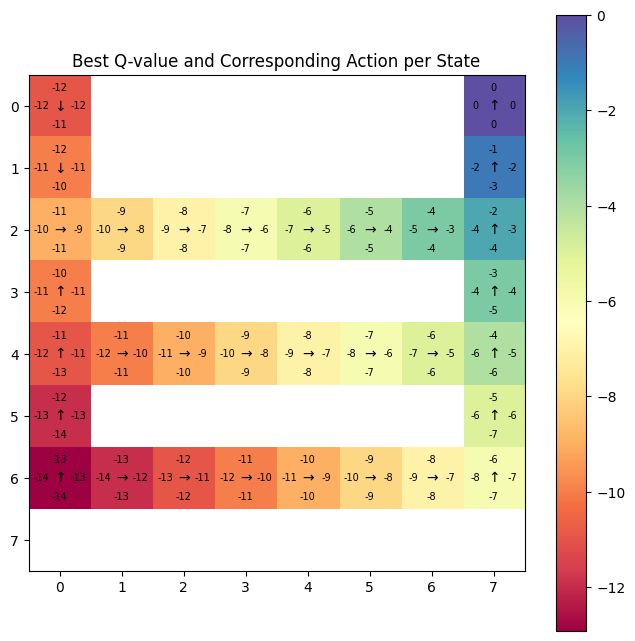

In [9]:
agent.plot_best_action_q_values()

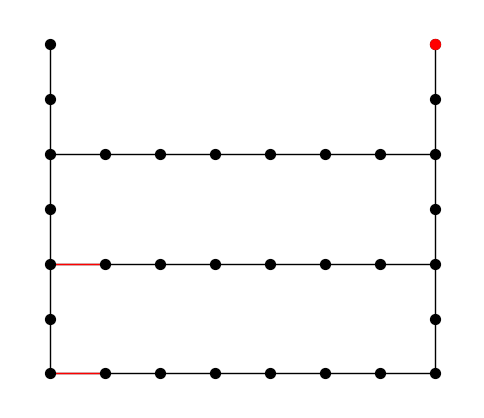

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [10]:
visualize_graph(G, env, critical_nodes, critical_edges)

In [11]:
from dmt import get_induced_gradient_vector_field, visualize_induced_vector_field

V = get_induced_gradient_vector_field(G)

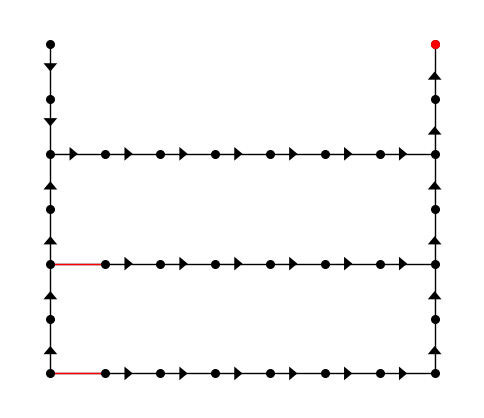

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [12]:
visualize_induced_vector_field(G, env, critical_nodes, critical_edges, V)

# Homology

Assume R coefficients.

In [13]:
from dmt import boundary_operator_r, betti_numbers

In [14]:
import seaborn as sns

<Axes: >

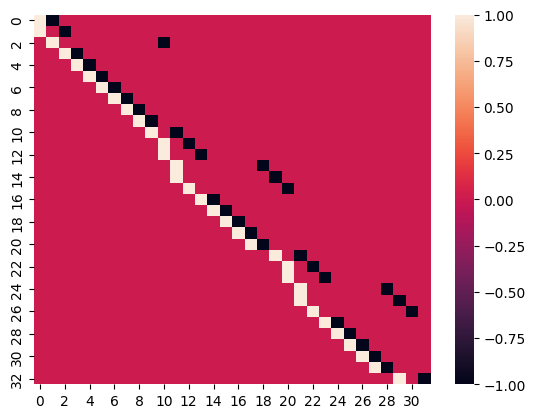

In [15]:
D = boundary_operator_r(G)
sns.heatmap(D)

In [16]:
def betti_numbers(G):
    D = boundary_operator_r(G)
    rank = np.linalg.matrix_rank(D)
    b_0 = D.shape[1] - rank
    b_1 = D.shape[0] - rank
    return b_0, b_1

In [17]:
b0, b1 = betti_numbers(G)

In [18]:
m0 = len(critical_nodes)
m1 = len(critical_edges)
chi = m0 - m1
print(chi)

-1


In [19]:
def euler_characteristic(G):
    V = G.number_of_nodes()
    E = G.number_of_edges()
    return V - E

In [20]:
euler_characteristic(G)

-1

# Homological sequences

For each critical value, compute the Betti numbers of the subcomplex of the graph.

Assumes the graph case for now.

In [21]:
def subcomplex(G, c):
    # Get the nodes whose Morse function value is less than or equal to c
    nodes = [node[0] for node in G.nodes(data=True) if -node[1]["node_value"] <= c]
    # Get the edges whose Morse function value is less than or equal to c
    edges = [edge[:2] for edge in G.edges(data=True) if -edge[2]["edge_value"] <= c]
    # Return the subgraph of G induced by these nodes and edges
    return G.edge_subgraph(edges).subgraph(nodes)

In [22]:
critical_values = [-v[-1]['node_value'] for v in critical_nodes] + [-e[-1]['edge_value'] for e in critical_edges]
critical_values = sorted(set(critical_values))

In [23]:
for c in critical_values:
    try:
        print(
            f"{betti_numbers(subcomplex(G, c))},\t {c:.02f})")
    except:
        pass

(1, 1),	 10.94)
(1, 2),	 12.92)


# Trained agent
Now let's do morse stuff on a learned Q function (over the course of training) instead of a pre-computed optimal Q function.

In [24]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=1, alpha=0.1)
agent.compute_optimal_q_function()
optimal_q_function = agent.q_table

Optimal Q-function computed.


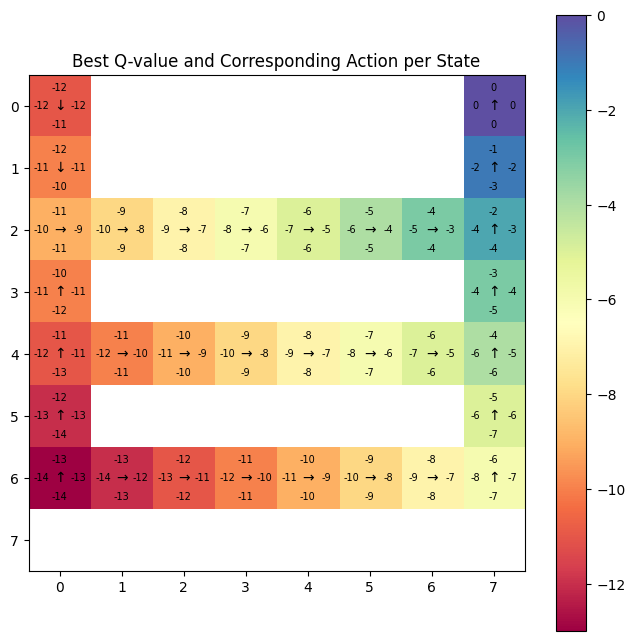

In [25]:
agent.plot_best_action_q_values()

In [26]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=0.999, alpha=0.1, epsilon_decay=0.95)
agent.train_with_summary(episodes=100, max_steps_per_episode=1000)
trained_q_function = agent.q_table

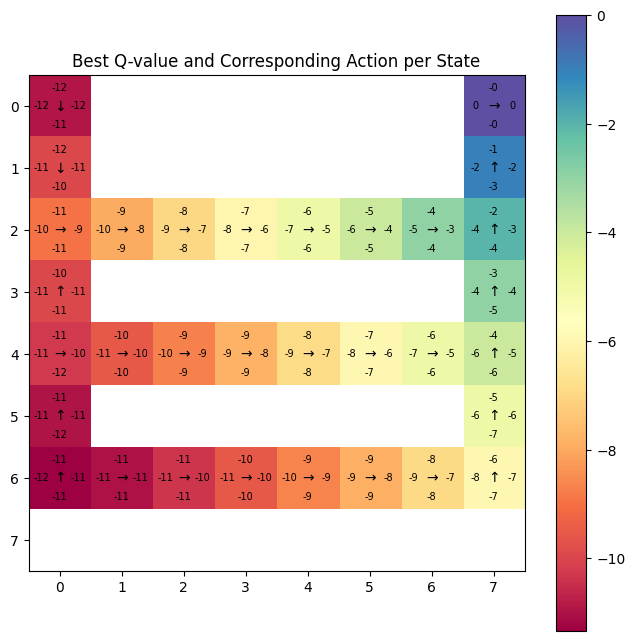

In [27]:
agent.plot_best_action_q_values()

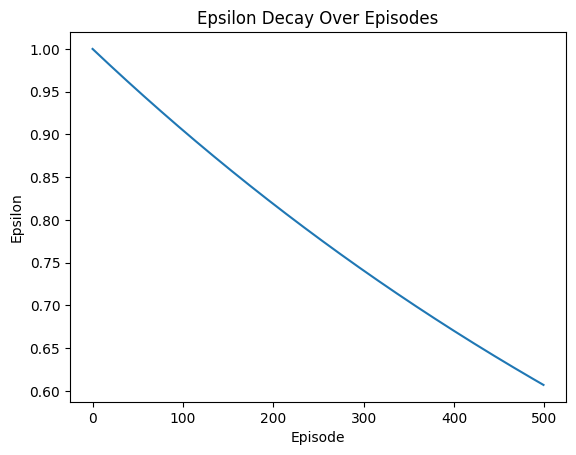

In [28]:
agent.plot_epsilon(500)

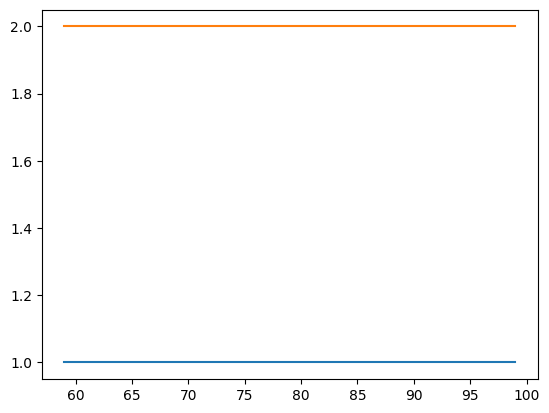

In [29]:
plt.plot([agent.summary[i]["m0"] for i in range(len(agent.summary))])
plt.plot([agent.summary[i]["m1"] for i in range(len(agent.summary))])

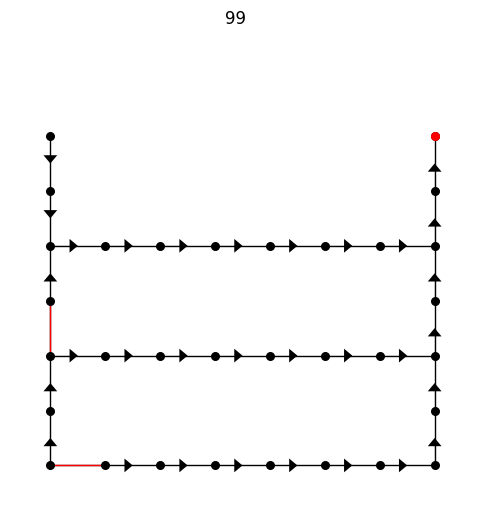

In [30]:
import IPython.display as display

fig, ax = plt.subplots(figsize=(6, 6))

for i in range(len(agent.summary)):
    fig.suptitle(f"{i}")

    data = agent.summary[i]
    if data["critical_nodes"] is None:
        fig, ax = visualize_graph(data["G"], env, [], [], figax=(fig, ax))
    else:
        fig, ax = visualize_induced_vector_field(
            data["G"],
            env,
            data["critical_nodes"],
            data["critical_edges"],
            data["induced_vector_field"],
            figax=(fig, ax),
        )
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1)
    ax.clear()

In [33]:
# debug:
# - make sure graph values make sense 
# - consider better ways of defining environment_to_graph

In [36]:
# when planning:
# with optimal q: a critical node iff it's an exit state
# so during training, auxiliary goal is...
# - to identify critical nodes that are not exit states? collapse them?
# - or some other strategy?
# point is to find some aux planning strategy to best update q fn based on morse structure
# warning: always compare to other search, depth-first etc
# because beating q learning is not hard in simple environments like this